In [1]:
# PROJECT/IMPLEMENTATION IDEAS
# 1. Historical market cap, % bitcoin (requires crawling https://coinmarketcap.com/historical/)
# 2. Twitter sentiment analysis of Bitcoin vs price
# 3. Bitcoin vs. altcoin market caps
# 4. Transaction fees, user/address count(?), other features(?) vs bitcoin price
# 5. Usage by country
# 6. Bitcoin trading by exchange
# 7. Bitcoin trading by currency
# 8. Increase in leverage?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from pandas.core import datetools
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import dateutil.parser
from pprint import pprint
import warnings; warnings.simplefilter('ignore')
import json
import time
import sys
import re
import datetime

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Helper functions
def to_currency(int):
    return "${:,.0f}".format(int//1000000)

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def list_to_average(list):
    try:
        avg = list[0]/list[1]
    except:
        avg = 0
    return avg

In [4]:
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['logBTCPrice','logETHPrice','logBTCVol','logTxFees','logCostperTxn','logNoTxns','logAvgBlkSz','logUniqueAddresses','logHashRate','logCrypto Market Cap','logNasdaq','logGold','logInterest','DateNum','Quarter','Month','Weekday']]
df_all = df
df_hist = df
df.head()

,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,DateNum,Quarter,Month,Weekday
2016-07-13,6.487181,2.356126,13.677656,10.454313,1.738710,12.296982,-0.261365,12.847761,14.232219,23.229166,8.518339,5.425787,1.098612,32.0,3.0,7.0,2.0
2016-07-14,6.486362,2.350422,13.679501,10.469753,1.621366,12.292677,-0.210721,12.813804,14.136909,23.229166,8.523982,5.424421,1.098612,33.0,3.0,7.0,3.0
2016-07-15,6.498043,2.442347,13.536535,10.561370,1.702928,12.304356,-0.235722,12.815710,14.225202,23.229166,8.523094,5.411646,1.098612,34.0,3.0,7.0,4.0
2016-07-17,6.498043,2.442347,13.536535,10.561370,1.702928,12.304356,-0.235722,12.815710,14.225202,23.279152,8.523094,5.411646,0.693147,34.0,3.0,7.0,4.0
2016-07-18,6.522313,2.429218,13.531194,10.390760,2.026832,12.049495,-0.356675,12.707847,14.273321,23.279152,8.528287,5.413564,0.693147,35.0,3.0,7.0,0.0


In [5]:
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,DateNum,Quarter,Month,Weekday
logBTCVol,-0.430067,-0.566407,1.000000,-0.469496,-0.457603,0.005784,-0.238210,-0.206018,-0.485545,-0.469849,-0.536602,-0.139956,-0.391810,-0.488723,0.316582,0.314345,0.058247
logGold,-0.296716,-0.231548,-0.139956,-0.344973,-0.246128,-0.386102,-0.371008,-0.430627,-0.343611,-0.267932,-0.344597,1.000000,-0.341400,-0.415066,-0.106912,-0.135795,-0.003407
Weekday,-0.010217,-0.010633,0.058247,0.041057,-0.054524,0.309140,0.197911,0.158610,-0.010638,-0.009988,-0.012348,-0.003407,-0.007680,-0.008257,-0.017060,-0.001424,1.000000
Month,0.070138,0.015310,0.314345,-0.058629,0.057282,-0.052625,-0.178515,-0.007222,-0.043116,0.026899,-0.095019,-0.135795,0.046241,-0.017941,0.972494,1.000000,-0.001424
Quarter,0.071455,0.017128,0.316582,-0.074736,0.060815,-0.082077,-0.178202,-0.030880,-0.035541,0.030675,-0.092903,-0.106912,0.036607,-0.015468,1.000000,0.972494,-0.017060
logNoTxns,0.408713,0.259439,0.005784,0.496745,0.298351,1.000000,0.635927,0.861895,0.413639,0.342232,0.386254,-0.386102,0.462138,0.391648,-0.082077,-0.052625,0.309140
logAvgBlkSz,0.580606,0.504811,-0.238210,0.682396,0.493815,0.635927,1.000000,0.702986,0.549255,0.553371,0.599602,-0.371008,0.605995,0.590215,-0.178202,-0.178515,0.197911
logUniqueAddresses,0.770760,0.648469,-0.206018,0.822317,0.695420,0.861895,0.702986,1.000000,0.759863,0.723741,0.741040,-0.430627,0.795811,0.746443,-0.030880,-0.007222,0.158610
logETHPrice,0.936719,1.000000,-0.566407,0.924925,0.949759,0.259439,0.504811,0.648469,0.928892,0.970350,0.942555,-0.231548,0.913048,0.937777,0.017128,0.015310,-0.010633
logNasdaq,0.958115,0.942555,-0.536602,0.948694,0.952842,0.386254,0.599602,0.741040,0.982124,0.964365,1.000000,-0.344597,0.945212,0.985271,-0.092903,-0.095019,-0.012348


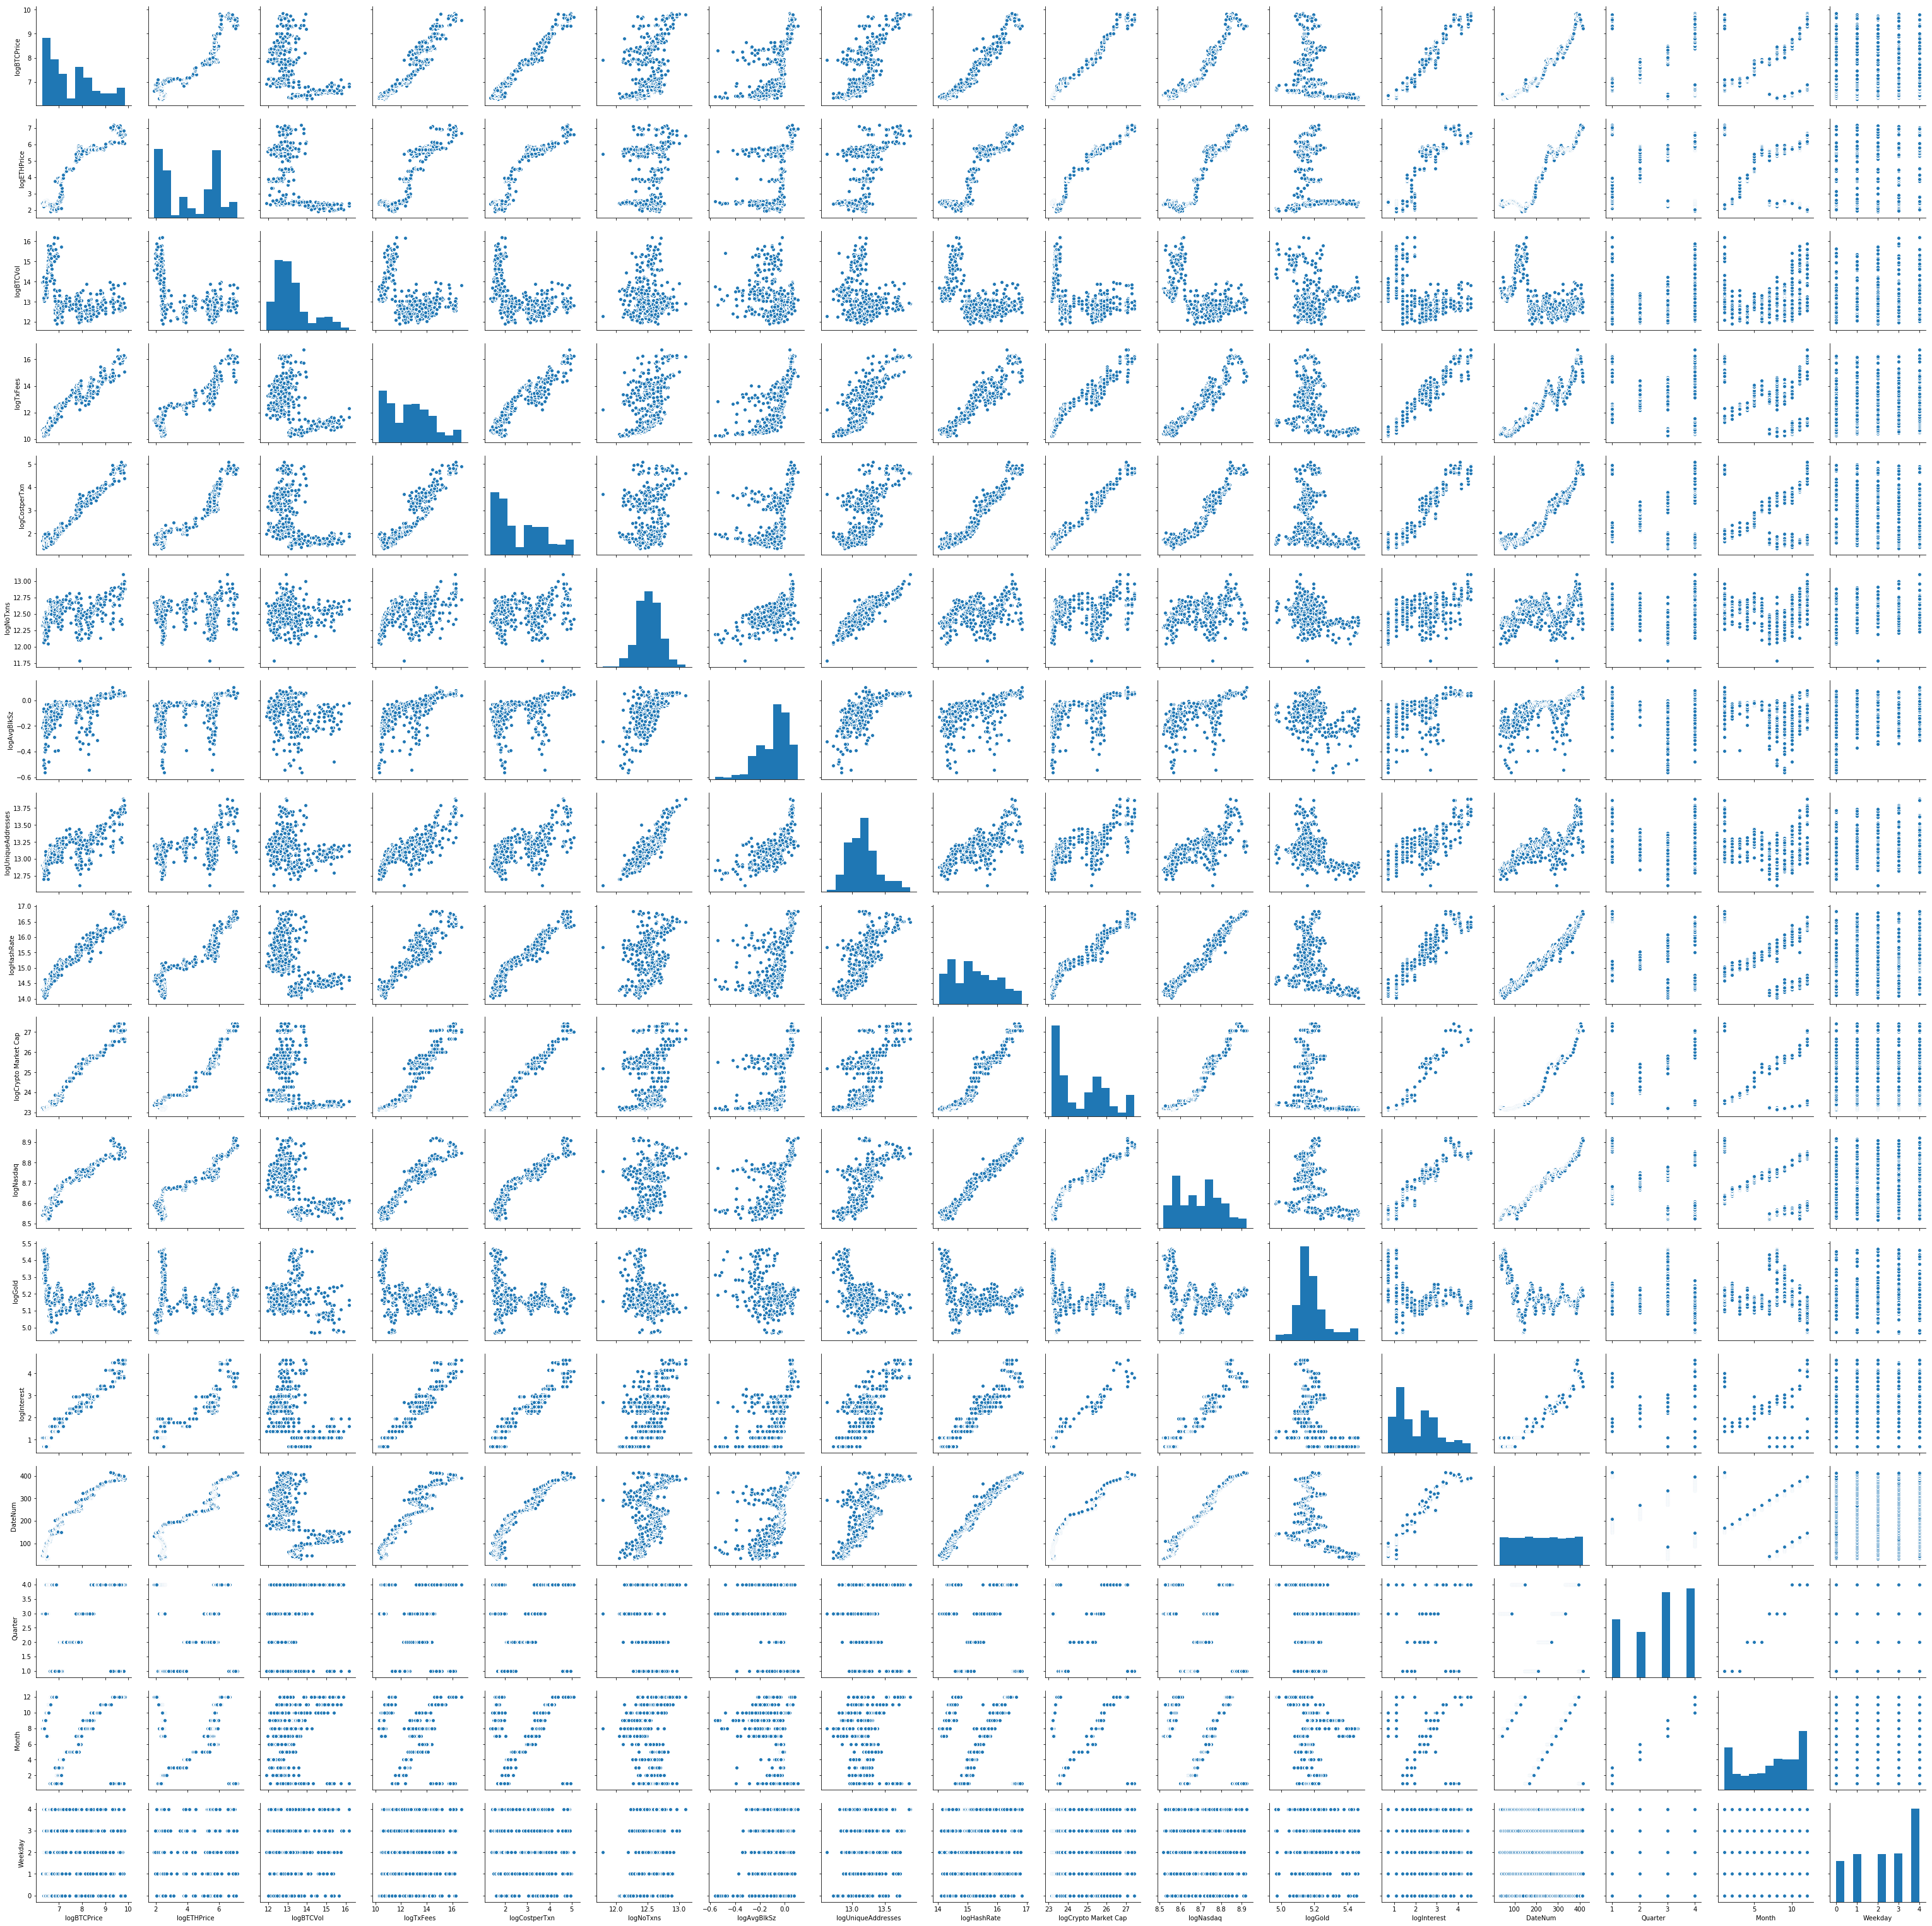

In [6]:
sns.pairplot(df_all)
plt.savefig('charts/featurepairplot.png')

In [7]:
# MAIN MODEL
# Reducing to few key features
df_all = df_all[['logBTCPrice','logNasdaq','logInterest','logTxFees']]
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logNasdaq,logInterest,logTxFees
logNasdaq,0.958115,1.000000,0.945212,0.948694
logTxFees,0.958548,0.948694,0.957145,1.000000
logInterest,0.977783,0.945212,1.000000,0.957145
logBTCPrice,1.000000,0.958115,0.977783,0.958548


'\nPossible leading indicators:\nGoogle Search Interest\n\n\nFollowing Indicators:\nCost per Transaction\nCrypto Market Cap\nEthereum Price\n'

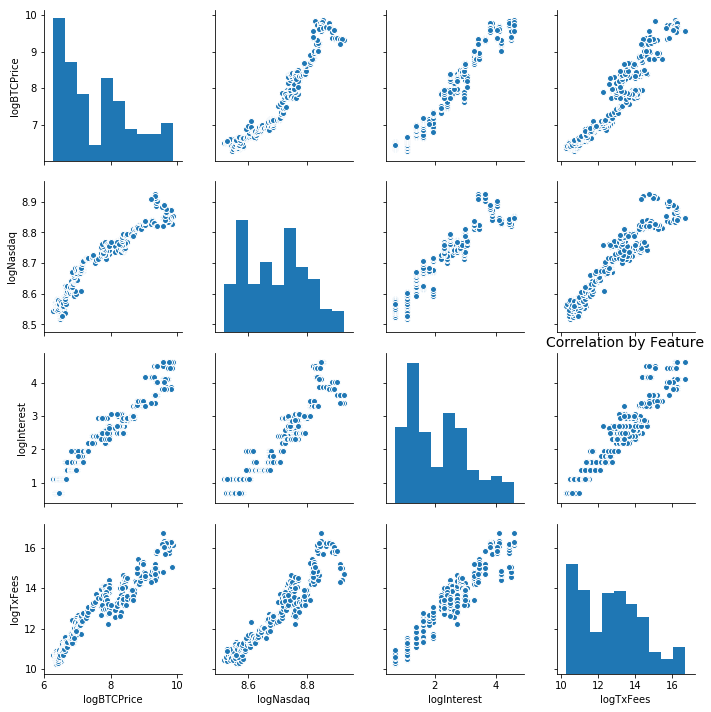

In [8]:
sns.pairplot(df_all)
plt.title('Correlation by Feature',fontsize=14)
plt.savefig('charts/modelpairplot.png')
'''
Possible leading indicators:
Google Search Interest


Following Indicators:
Cost per Transaction
Crypto Market Cap
Ethereum Price
'''

In [9]:
df = df_all
# STATSMODELS
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('logBTCPrice ~ logInterest + logNasdaq + logTxFees', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4647.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:34:25   Log-Likelihood:                 127.12
No. Observations:                 465   AIC:                            -246.2
Df Residuals:                     461   BIC:                            -229.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -17.4446      2.346     -7.435      0.000     -22.055     -12.834
logInterest     0.5879      0.031     19.129      0.000       0.528       0.648
logNasdaq       2.6151      0.286      9.142      0.000       2.053       3.177
logTxFees       0.0826      0.020      4.060      0.000       0.043       0.123
==============================================================================
Omnibus:                        7.400   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.008
Skew:                          -0.255   Prob(JB):                       0.0301
Kurtosis:                       2.680   Cond. No.                     4.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['logInterest','logNasdaq','logTxFees']]
# Choose the response variable(s)
y = df['logBTCPrice']
# Fit the model to the full dataset
lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))
print(lr.intercept_)
print(lr.coef_)

0.9679894231759163
-17.444552944338874
[0.5879255  2.61505401 0.08263977]


Text(0.5,1,'Residual over time')

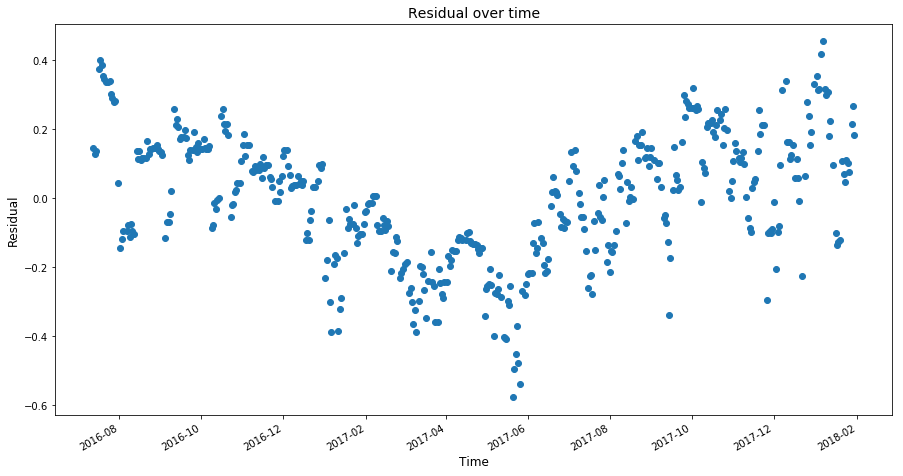

In [11]:
# Use statsmodels to plot the residuals
# Note that residuals are not random and will require further adjustments at a later time.  
fit.resid.plot(style='o', figsize=(15,8));
plt.ylabel("Residual",fontsize=12)
plt.xlabel("Time",fontsize=12)
plt.title('Residual over time',fontsize=14)

(array([0.08344772, 0.08344772, 0.04172386, 0.33379089, 0.33379089,
        0.66758178, 1.0848204 , 0.95964881, 1.87757376, 2.16964079,
        1.20999198, 1.71067832, 1.79412604, 2.87894644, 1.58550673,
        0.91792495, 0.79275337, 0.58413406, 0.20861931, 0.08344772]),
 array([-0.57693866, -0.5253965 , -0.47385435, -0.4223122 , -0.37077004,
        -0.31922789, -0.26768574, -0.21614359, -0.16460143, -0.11305928,
        -0.06151713, -0.00997498,  0.04156718,  0.09310933,  0.14465148,
         0.19619363,  0.24773579,  0.29927794,  0.35082009,  0.40236224,
         0.4539044 ]),
 <a list of 20 Patch objects>)

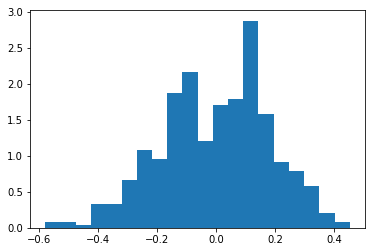

In [14]:
y_pred = lr.predict(X)

residuals = y - y_pred
plt.hist(residuals, bins = 20, normed=True)
# plt.xlabel()

In [15]:
# The cross validation for a time series would be as follows:
# split = int(round(len(df) * 0.9,0))
# X_train, X_test, y_train, y_test = df.iloc[:split,1:], df.iloc[split:,1:],df.iloc[:split,0],df.iloc[split:,0]
# Due to project requirements, I am using the standard linear regression train-test split for this analysis.

In [16]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.7)

# Fit the model against the training data
lr.fit(X_train, y_train)
# # Evaluate the model against the testing data
lr.score(X_test, y_test)

0.9718212595831236

In [17]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.965429326501643
0.9718212595831236


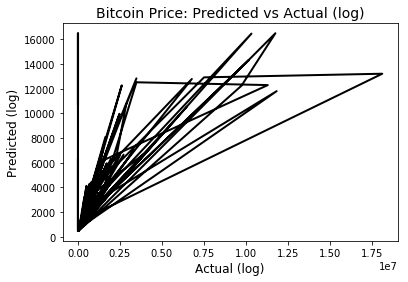

In [28]:
# sklearn prediction (logBTCPrice)
y = y_test
fig, ax = plt.subplots()
# ax.scatter(y_test, lr.predict(X_test),c='#F39C12')
ax.plot(np.exp(X_test), np.exp(lr.predict(X_test)),'black',lw=2)
ax.set_xlabel('Actual (log)',fontsize=12)
ax.set_ylabel('Predicted (log)',fontsize=12)
plt.title('Bitcoin Price: Predicted vs Actual (log)',fontsize=14)
plt.show()

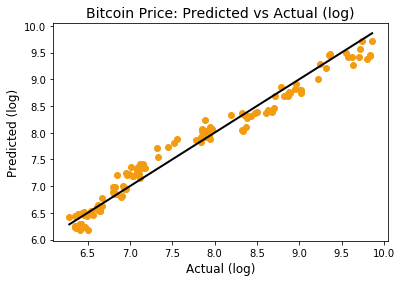

In [30]:
# sklearn prediction (logBTCPrice)
y = y_test
fig, ax = plt.subplots()
ax.scatter(y_test, lr.predict(X_test),c='#F39C12')
ax.plot([y.min(), y.max()], [y.min(), y.max()],'black',lw=2)
ax.set_xlabel('Actual (log)',fontsize=12)
ax.set_ylabel('Predicted (log)',fontsize=12)
plt.title('Bitcoin Price: Predicted vs Actual (log)',fontsize=14)
plt.show()

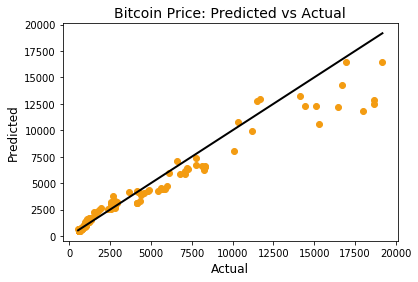

In [42]:
# sklearn prediction (BTCPrice)
fig, ax = plt.subplots()
ax.scatter(np.exp(y_test), np.exp(lr.predict(X_test)),c='#F39C12')
y_min = np.exp(y_test.min())
y_max = np.exp(y_test.max())
ax.plot([y_min, y_max], [y_min, y_max],'black',lw=2)
ax.set_xlabel('Actual',fontsize=12)
ax.set_ylabel('Predicted',fontsize=12)
plt.title('Bitcoin Price: Predicted vs Actual',fontsize=14)
plt.show()

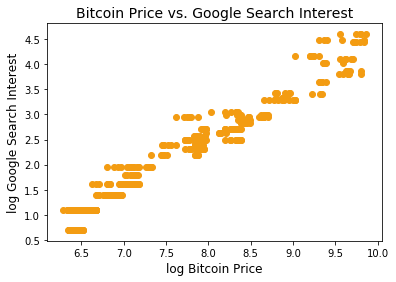

In [21]:
x = df['logBTCPrice']
y = df['logInterest']

plt.scatter(x,y,c='#F39C12')
plt.title('Bitcoin Price vs. Google Search Interest',fontsize=14)
plt.xlabel('log Bitcoin Price',fontsize=12)
plt.ylabel('log Google Search Interest',fontsize=12)
plt.savefig('charts/interestvsbtcprice.png')

In [22]:
y, X = patsy.dmatrices('logBTCPrice ~ logInterest', data=df, return_type="dataframe")

# Create your model
model2 = sm.OLS(y,X)
# Fit your model to your training set
fit2 = model2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.007e+04
Date:                Wed, 31 Jan 2018   Prob (F-statistic):          2.52e-316
Time:                        17:36:31   Log-Likelihood:                 53.475
No. Observations:                 465   AIC:                            -102.9
Df Residuals:                     463   BIC:                            -94.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5699      0.022    249.966      0.000       5.526       5.614
logInterest     0.9545      0.010    100.370      0.000       0.936       0.973
==============================================================================
Omnibus:                        9.876   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.223
Skew:                          -0.304   Prob(JB):                      0.00603
Kurtosis:                       3.399   Cond. No.                         5.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

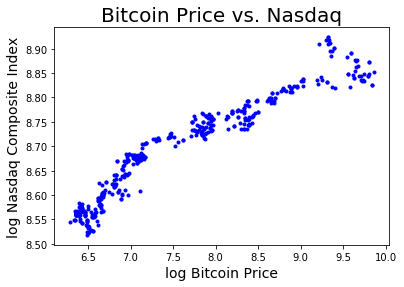

In [23]:
x = df['logBTCPrice']
y = df['logNasdaq']

plt.plot(x,y,'b.')
plt.title('Bitcoin Price vs. Nasdaq',fontsize=20)
plt.xlabel('log Bitcoin Price',fontsize=14)
plt.ylabel('log Nasdaq Composite Index',fontsize=14)
plt.savefig('charts/nasdaqvsbtcprice.png')

In [24]:
y, X = patsy.dmatrices('logBTCPrice ~ logNasdaq', data=df, return_type="dataframe")

# Create your model
model3 = sm.OLS(y,X)
# Fit your model to your training set
fit3 = model3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5182.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):          1.43e-253
Time:                        17:36:32   Log-Likelihood:                -91.626
No. Observations:                 465   AIC:                             187.3
Df Residuals:                     463   BIC:                             195.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.0447      1.148    -65.389      0.000     -77.300     -72.789
logNasdaq      9.5038      0.132     71.988      0.000       9.244       9.763
==============================================================================
Omnibus:                       23.141   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.197
Skew:                           0.547   Prob(JB):                     3.38e-06
Kurtosis:                       3.323   Cond. No.                         738.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Resources
# https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
# http://cs229.stanford.edu/proj2015/029_report.pdf
# http://text-processing.com/ API
# https://trends.google.com/trends/explore?q=bitcoin,ethereum